# CryptoPals challenges 7-16

#### the following are my solutions + explanations to the second set of the cryptopals challenges, other set solutions can be found at my [github](https://github.com/lordofswords)

##### the challenges will not be solved in their order, but rather in the order that makes the code most readable throughout.

## Challenge 9 + 15: Implement PKCS#7 padding and validation

[<strong> description (9)</strong>](https://cryptopals.com/sets/2/challenges/9): <br>
>  A block cipher transforms a fixed-sized block (usually 8 or 16 bytes) of plaintext into ciphertext. But we almost never want to transform a single block; we encrypt irregularly-sized messages. <br> <br>
One way we account for irregularly-sized messages is by padding, creating a plaintext that is an even multiple of the blocksize. The most popular padding scheme is called PKCS#7. <br><br>
So: pad any block to a specific block length, by appending the number of bytes of padding to the end of the block. For instance, <br><br>
"YELLOW SUBMARINE" <br><br>
... padded to 20 bytes would be: <br> <br>
"YELLOW SUBMARINE\x04\x04\x04\x04"

[<strong> description (15)</strong>](https://cryptopals.com/sets/2/challenges/15): <br>
>  Write a function that takes a plaintext, determines if it has valid PKCS#7 padding, and strips the padding off.
<br><br>
The string:
<br><br>
"ICE ICE BABY\x04\x04\x04\x04"
<br><br>
... has valid padding, and produces the result "ICE ICE BABY".
<br><br>
The string:
<br><br>
"ICE ICE BABY\x05\x05\x05\x05"
<br><br>
... does not have valid padding, nor does:
<br><br>
"ICE ICE BABY\x01\x02\x03\x04"
<br><br>
If you are writing in a language with exceptions, like Python or Ruby, make your function throw an exception on bad padding.
<br><br>
Crypto nerds know where we're going with this. Bear with us. 

We Start the second set of challenges by implementing Pkcs#7 padding. important to note - if we have text of size 16 for instance, we need to append to it 16 more padding bytes to length 32, i.e. padding of length 0 is invalid.

In [60]:
class PKCS7Error(Exception):
    """ An Exception for pkcs7 padding errors. """

    def __init__(self, bad_padding : bytes, block_size = 16):
        """Takes a bad padding, and generates information about why its bad"""
        self.block_size = block_size
        self.bad_padding = bad_padding
        # the last byte of a valid padding is the padding size.
        padding_size = bad_padding[-1]
        # check whether the padding size is too large:
        if padding_size >= block_size:
            self.msg = "bad padding:\n {}, padding size is: {} > {} = block_size"    
            self.msg = self.msg.format(bad_padding, padding_size, len(bad_padding))
        
        else:
            self.msg = "bad padding:\n {}, padding size is: {}, however, byte #{} = {}"
            # in a valid padding, the previous {padding_size} bytes should all be equal to padding size
            # i.e "\x04\x04\x04\x04" is a valid padding
            # "\x03\x03\x02\x04" is invalid

            # find first occurence of invalid padding, the first "\x03" above for example
            for idx, c in enumerate(bad_padding):
                # found first invalid byte
                if c != padding_size:
                    # update the message with information and generate the exception
                    msg = msg.format(bad_padding, padding_size, idx+1, c)
                    break

        super().__init__(self.msg)


def add_PKCS7(plaintext : bytes, block_size = 16) -> bytes:
    """ Takes a plaintext and returns the plaintext with appended pkcs7 padding """

    # calculate padding size based on how many bytes are missing for the last block to be complete.
    # i.e. "b"*16 + "aaaa------------" is missing 12 bytes in its 'aaaa' block
    padding_size = block_size - len(plaintext)%block_size
    # return the plaintext with the padding appended in bytes format
    return plaintext + bytes([padding_size]*padding_size)
    
def validate_and_remove_PKCS7(plaintext_with_padding : bytes, block_size = 16) -> bytes:
    """Takes a plaintext that has been decrypted, and verifies its pkcs7 padding is valid, else raise PKCS7Error"""

    # in a valid padding, the padding size is stored in the last byte.
    padding_size = plaintext_with_padding[-1]
    # if padding size is too large, raise an exception
    if padding_size >= block_size:
        raise PKCS7Error(plaintext_with_padding, block_size)

    # in a valid padding, the previous {padding_size} bytes should all be equal to padding size
    # i.e "\x04\x04\x04\x04" is a valid padding
    # "\x03\x03\x02\x04" is invalid
    padding = plaintext_with_padding[-padding_size:]
    if padding == bytes([padding_size]*padding_size): # valid padding
        return plaintext_with_padding[:-padding_size]
    raise PKCS7Error(padding)

In [61]:
add_PKCS7(b"YELLOW SUBMARINE", 20)
validate_and_remove_PKCS7(b"YELLOW SUBMARINE\x04\x04\x04\x04", 20)

b'YELLOW SUBMARINE'

Also, let us update the `ECB_encrypt` method from challenge 7 to also use padding:

## Challenge 7: AES in ECB mode

[<strong> description</strong>](https://cryptopals.com/sets/1/challenges/7): <br>
> The Base64-encoded content in this [file](https://cryptopals.com/static/challenge-data/7.txt) has been encrypted via AES-128 in ECB mode under the key <br>  <br>
"YELLOW SUBMARINE". <br> <br>
(case-sensitive, without the quotes; exactly 16 characters; I like "YELLOW SUBMARINE" because it's exactly 16 bytes long, and now you do too). <br> <br>
Decrypt it. You know the key, after all.

The description of how the AES cipher works can be found at the official [fips](http://nvlpubs.nist.gov/nistpubs/FIPS/NIST.FIPS.197.pdf), however, in my opinion it is better described by [computerphile](https://youtu.be/O4xNJsjtN6E)

I'll be using the [cryptography](https://cryptography.io/) libary, as it provides a python interface for using the algorithms while using low level implementations thus not impacting performance as much.

In [62]:
from base64 import b64decode, b64encode

from cryptography.hazmat.primitives.ciphers import ( 
    Cipher, algorithms, modes
)

class Block_size_error(Exception):
    def __init__(self, ciphertext : bytes, block_size = 16) -> bytes:
        self.msg = f"The ciphertext is incomplete or too long, the length of its last block is \
                    = {len(ciphertext) % block_size} ; while its actual block size = {block_size}"
        
        super().__init__(self.msg)


''' A utility function that will come very handy '''

def split_to_blocks(text, block_size = 16):
    blocks = []
    for i in range(0, len(text), block_size):
        curr_block = text[i : i + block_size]
        blocks.append(curr_block)
    return blocks


class AES_ECB:
    """ A class for encrypting and decrypting with AES in ECB mode. will be using pkcs#7 padding for enc/dec."""
    def __init__(self, key : bytes) -> bytes:
        """ Create an instance with a key that will be used for all further enc/dec tasks of this instace"""
        self.block_size = 16
        self.cipher = Cipher(algorithms.AES(key), modes.ECB())
        self.keysize = len(key)*8


    def decrypt_no_padding(self, ciphertext : bytes) -> bytes:
        """ decrypt a block of ciphertext using the provided key. 
        ciphertext size must be a multiple of 16."""

        if len(ciphertext) % self.block_size != 0:
            raise Block_size_error(ciphertext)

        # generate cipher decryptor using cryptography libary.
        decryptor = self.cipher.decryptor()
        ciphertext_blocks = split_to_blocks(ciphertext, self.block_size)

        plaintext_blocks = []        
        # go through the blocks and decrypt them one at a time
        for curr_ciphertext_block in ciphertext_blocks:
            decrypted_block = decryptor.update(curr_ciphertext_block)
            plaintext_blocks.append(decrypted_block)

        decryptor.finalize()

        plaintext = b''.join(plaintext_blocks)
        return plaintext

    def decrypt(self, ciphertext : bytes) -> bytes:
        padded_plaintext = self.decrypt_no_padding(ciphertext)
        plaintext = validate_and_remove_PKCS7(padded_plaintext)
        return plaintext

    def decrypt_file(self, filepath) -> bytes:
        """ Decrypts a file encrypted using AES-ECB with self.key then encoded in b64 """
        file_contents = b64decode(open(filepath).read())
        return self.decrypt(file_contents)


    def encrypt_without_padding(self, plaintext : bytes) -> bytes:
        """ Encrypts the plaintext using AES-ECB with self.key """
        encryptor = self.cipher.encryptor()
        plaintext_blocks = split_to_blocks(plaintext, self.block_size)

        ciphertext_blocks = []
        # one block at a time, encrypt the plaintext
        for curr_plaintext_block in plaintext_blocks:
            encrypted_block = encryptor.update(curr_plaintext_block)
            ciphertext_blocks.append(encrypted_block)
        
        encryptor.finalize()

        ciphertext = b''.join(ciphertext_blocks)
        return ciphertext

    def encrypt(self, plaintext : bytes) -> bytes:
        padded_plaintext = add_PKCS7(plaintext)
        return self.encrypt_without_padding(padded_plaintext)

    def encrypt_file(self, filepath, newfile_path = None) -> None:
        """ encrypts a file, then saves b64 of the result,
         if no path for a new file is provided, overwrites the original file """

        file_content = open(filepath, 'rb').read()
        encrypted_file_content = self.encrypt(file_content)

        if newfile_path is None:
            newfile_path = filepath
        
        open(newfile_path, 'w').write(b64encode(encrypted_file_content))


In [63]:
KEY = b"YELLOW SUBMARINE"
decryptor = AES_ECB(KEY)
decryptor.decrypt_file("input_files/7.txt")[:51]

b"I'm back and I'm ringin' the bell \nA rockin' on the"

## Challenge 8: Detect AES in ECB mode 

[<strong> description</strong>](https://cryptopals.com/sets/1/challenges/8): <br> <br>
>  In this [file](https://cryptopals.com/static/challenge-data/8.txt) are a bunch of hex-encoded ciphertexts. <br> <br>
One of them has been encrypted with ECB. <br> <br>
Detect it. <br> <br>
Remember that the problem with ECB is that it is stateless and deterministic; the same 16 byte plaintext block will always produce the same 16 byte ciphertext.

Solution: we use the fact the ECB generates the same cipher-block for the same plain-block, therefore an easy (and the only one i am aware of) for detecting it, is looking for 2 blocks with the same value:  
we split every line into 16-bytes long blocks, and find the line for which two blocks are the same. this image pretty much says it all:  
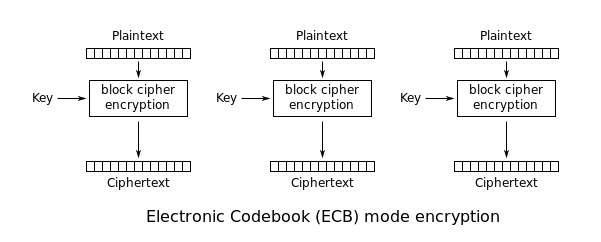

In [64]:
from collections import Counter
from binascii import unhexlify

class Chall8:
    @staticmethod
    def get_lines(filepath):
        return [unhexlify(line) for line in open(filepath).read().splitlines()]
    
    @staticmethod
    def split_line_2_blocks(line, block_size = 16):
        byte_blocks = [line[16*i:16*(i+1)] for i in range((len(line)+15)//16)]
        return dict(Counter(byte_blocks))
    
    @staticmethod
    def is_ECB_mode(ciphertext):
        ciphertext_block_cnt = Chall8.split_line_2_blocks(ciphertext)
        return any(x > 2 for x in ciphertext_block_cnt.values())
    
    @staticmethod
    def find_ecbEncryptedText(filepath):
        for row_num, line in enumerate(Chall8.get_lines(filepath)):
            if Chall8.is_ECB_mode(line):
                print(f"potential ecb-encrypted row: {row_num+1}")

In [65]:
Chall8.find_ecbEncryptedText("input_files/8.txt")

potential ecb-encrypted row: 133


#  Set 2

## Challenge 10: Implement CBC mode

[<strong> description</strong>](https://cryptopals.com/sets/2/challenges/10): <br>
>  CBC mode is a block cipher mode that allows us to encrypt irregularly-sized messages, despite the fact that a block cipher natively only transforms individual blocks. <br><br>
In CBC mode, each ciphertext block is added to the next plaintext block before the next call to the cipher core. <br><br>
The first plaintext block, which has no associated previous ciphertext block, is added to a "fake 0th ciphertext block" called the initialization vector, or IV.
<br><br>
Implement CBC mode by hand by taking the ECB function you wrote earlier, making it encrypt instead of decrypt (verify this by decrypting whatever you encrypt to test), and using your XOR function from the previous exercise to combine them.
<br><br>
The [file](https://cryptopals.com/static/challenge-data/10.txt) here is intelligible (somewhat) when CBC decrypted against "YELLOW SUBMARINE" with an IV of all ASCII 0 (\x00\x00\x00 &c)
Don't cheat.
<br><br>
Do not use OpenSSL's CBC code to do CBC mode, even to verify your results. What's the point of even doing this stuff if you aren't going to learn from it?

This is more of an understanding + implementation task, however i feel the challenge is really well explained with the following 2 pictures:

![encryption](img/CBC_encryption.png)

![decryption](img/CBC_decryption.png)

In [66]:
""" if you'd recall, we implemented a fixed XOR func in chall 1-6, here is it's code: """
def fixed_XOR(s1 : bytes, s2 : bytes) -> bytes:
    return bytes(b1^b2 for b1, b2 in zip(s1, s2))

In [67]:
from base64 import b64encode, b64decode

class AES_CBC:
    ''' this class uses the AES_ECB class from challenge 7 with encapsulation, as it seemed more appropriate than inheritance'''
    def __init__(self, key : bytes, iv=b"\x00"*16):
        self.ECB_engine = AES_ECB(key)
        self.iv = iv
        self.block_size = len(iv)
    
    def decrypt_no_padding(self, ciphertext : bytes) -> bytes:
        ''' Invariant: len(ciphertext) % self.block_size = 0 '''
        plain_blocks = []
        blocks = split_to_blocks(ciphertext, self.block_size)

        previous_block = self.iv

        for block in blocks:
            decrypted_block = self.ECB_engine.decrypt_no_padding(block)
            plaintext_block = fixed_XOR(decrypted_block, previous_block)
            plain_blocks.append(plaintext_block)
            previous_block = block

        return b''.join(plain_blocks)

    def decrypt(self, ciphertext : bytes) -> bytes:
        ''' Invariant: len(ciphertext) % self.block_size = 0 '''
        padded_plaintext = self.decrypt_no_padding(ciphertext)
        plaintext = validate_and_remove_PKCS7(padded_plaintext)
        return plaintext

    def decrypt_file(self, filepath) -> bytes:
        """ Decrypts a file encrypted using AES-CCB with self.key and self.iv then encoded in b64 """
        file_contents = b64decode(open(filepath).read())
        return self.decrypt(file_contents)

    def encrypt_without_padding(self, plaintext : bytes) -> bytes:
        ''' Invariant: len(plaintext) % self.block_size = 0 '''
        ciphertext_blocks = []
        blocks = split_to_blocks(plaintext, self.block_size)

        previous_block = self.iv
        
        for block in blocks:
            xored_block = fixed_XOR(block, previous_block)
            cipher_block = self.ECB_engine.encrypt_without_padding(xored_block)
            ciphertext_blocks.append(cipher_block)
            previous_block = cipher_block
            
        return b''.join(ciphertext_blocks)

    def encrypt(self, plaintext : bytes) -> bytes:
        padded_plaintext = add_PKCS7(plaintext)
        return self.encrypt_without_padding(padded_plaintext)

    def encrypt_file(self, filepath, newfile_path = None) -> None:
        """ encrypts a file, then saves b64 of the result,
         if no path for a new file is provided, overwrites the original file """

        file_content = open(filepath, 'rb').read()
        encrypted_file_content = self.encrypt(file_content)

        if newfile_path is None:
            newfile_path = filepath
        
        open(newfile_path, 'w').write(b64encode(encrypted_file_content))

In [68]:
KEY = b"YELLOW SUBMARINE"
decryptor = AES_CBC(KEY)
decryptor.decrypt_file("input_files/10.txt")[:51]

b"I'm back and I'm ringin' the bell \nA rockin' on the"

## Challenge 11: An ECB/CBC detection oracle

[<strong> description</strong>](https://cryptopals.com/sets/2/challenges/11): <br>
> Now that you have ECB and CBC working:
<br><br>
Write a function to generate a random AES key; that's just 16 random bytes.
<br><br>
Write a function that encrypts data under an unknown key --- that is, a function that generates a random key and encrypts under it.
<br><br>
The function should look like:
<br><br>
encryption_oracle(your-input)
=> [MEANINGLESS JIBBER JABBER]
<br><br>
Under the hood, have the function append 5-10 bytes (count chosen randomly) before the plaintext and 5-10 bytes after the plaintext.
<br><br>
Now, have the function choose to encrypt under ECB 1/2 the time, and under CBC the other half (just use random IVs each time for CBC). Use rand(2) to decide which to use.
<br><br>
Detect the block cipher mode the function is using each time. You should end up with a piece of code that, pointed at a block box that might be encrypting ECB or CBC, tells you which one is happening. 

This is the only challenge so far that felt kinda weird, maybe even pointless. nontheless, here is how i think you should solve it: (using the same ECB detection scheme from challenge 8)

In [69]:
import secrets
import random
import string

def gen_random_bytes(min_count, max_count) -> bytes:
    return bytes([secrets.randbelow(256) for i in range(
    random.randint(min_count, max_count))])

class Chall11:
    
    def encryption_oracle(plaintext : bytes):
        rand_key = gen_random_bytes(16, 16)
        pre = gen_random_bytes(5, 10)
        post = gen_random_bytes(5, 10)
        plaintext = pre + plaintext + post

        first_half, second_half = plaintext[:len(plaintext)//2], plaintext[len(plaintext)//2:]
        if random.choice([True, False]):
            first_half, second_half = second_half, first_half

        ecb_encryptor = AES_ECB(rand_key)
        cbc_encryptor = AES_CBC(rand_key, gen_random_bytes(16, 16))

        first_half_enc = ecb_encryptor.encrypt(first_half)
        second_half_enc = cbc_encryptor.encrypt(second_half)

        return first_half_enc, second_half_enc
    
    def detection_oracle(ciphertext : bytes):
        """returns true if the ciphertext was encrypted with ECB, else false"""
        block_dict = Chall8.split_line_2_blocks(ciphertext)
        return any(x > 2 for x in block_dict.values())

## Challenge 12: Byte-at-a-time ECB decryption (Simple)

[<strong> description</strong>](https://cryptopals.com/sets/2/challenges/12): <br>
> Byte-at-a-time ECB decryption (Simple)
<br><br>
Copy your oracle function to a new function that encrypts buffers under ECB mode using a consistent but unknown key (for instance, assign a single random key, once, to a global variable).
<br><br>
Now take that same function and have it append to the plaintext, BEFORE ENCRYPTING, the following string:
<br><br>
Um9sbGluJyBpbiBteSA1LjAKV2l0aCBteSByYWctdG9wIGRvd24gc28gbXkg
aGFpciBjYW4gYmxvdwpUaGUgZ2lybGllcyBvbiBzdGFuZGJ5IHdhdmluZyBq
dXN0IHRvIHNheSBoaQpEaWQgeW91IHN0b3A/IE5vLCBJIGp1c3QgZHJvdmUg
YnkK
<br><br>
Spoiler alert.
<br><br>
Do not decode this string now. Don't do it.
<br><br>
Base64 decode the string before appending it. Do not base64 decode the string by hand; make your code do it. The point is that you don't know its contents.
<br><br>
What you have now is a function that produces:
<br><br>
AES-128-ECB(your-string || unknown-string, random-key)
<br><br>
It turns out: you can decrypt "unknown-string" with repeated calls to the oracle function! 

Firstly, we should implement the oracle so that we have some code in front of our eyes to better understand:

In [70]:
from base64 import b64decode
import os

""" the following would be unknown in a real-life scenario, consider it 'backend' code """
KEY = os.urandom(16)
ecb_engine = AES_ECB(KEY)

unknown_string = b64decode("Um9sbGluJyBpbiBteSA1LjAKV2l0aCBteSByYWctdG9wIGRvd24gc28gbXkgaGFpciBjYW4gYmxvdwpUaGUgZ2ly" +
                    "bGllcyBvbiBzdGFuZGJ5IHdhdmluZyBqdXN0IHRvIHNheSBoaQpEaWQgeW91IHN0b3A/IE5vLCBJIGp1c3QgZHJvdmUg")

def enc_oracle_chall12(plaintext):
    assert len(plaintext) > 0, "null input isn't allowed in oracle"
    return ecb_engine.encrypt(plaintext+unknown_string)

<strong> The attack plan: </strong>
1. discover the block_size and the padding-size. this is done rather simply:
    1. call the oracle function with input string of `'A'` then `'AA'` then `'AAA'` etc...
    2. record the initial result length for the single byte 'A'.
    3. when the result changes we discover 2 things:
        1. the block_size: just compare the new cipher-size to the initial result. the diff is the block size.
        2. the padding_size: the padding is the same as the ammount of A's added before the change, unless its block_size + 1, in which case the padding size is 1. (we created a new block by adding the first 'A') <br><br>
2. discover how many block there are, this can be done by using `input := 'A'*block_size`, count how many blocks there are in this ciphertext and decrement by 1. <br><br>
3. discover every block but the last one in the same manner:
    1. discover the first byte of the block by using '`A'*(block_size-1)`. what we will get in the equivalent `cipher_block` is `AES_ECB(key, prev_block[1:] + curr_block[0])`. <br><br>
    2. since we already know the result of `AES_ECB(key, prev_block)` (for the initial prev_block, just use `'A'*16` and find out its result by examining `ciphertext[:16]`), just run through all 256 possibilities for `curr_block[0]` until we get the one that results in the same cipher_block. <br><br>
    3. discover the second byte by using `'A'*(block_size-2)`. we will get the result of `AES_ECB(key, prev_block[2:] + curr_block[:2])`, but we already know `curr_block[0]` so crack `curr_block[1]` in the same process as (2). <br><br>
    4. repeat for all bytes in the block but the last one, this one is a bit trickier since we can't do `oracle("")` <br><br>
    5. The last byte: use a full blocksize*"A" input to the oracle, then look at the next block instead of the current one. its exactly the same as the first byte discovery but this time instead of `prev_block` we use the `block_size-1` bytes we already discovered. <br><br>
    6. call the function again, but this time with an updated prev_block. <br><br>
4. this one is almost identical to 3, but we need to take into account the `padding_size`, so do (3), but not until we get the whole block, but only until we get the exact ammount of non-padding bytes in it. <br><br>
5. concatenate all discovered bytes and return the result. WE WIN :)

NOTE: a dictionary should be used since there are multiple uses of the same function calls with the same input (for instance using `input = 'A'`)

In [71]:
from collections.abc import Callable

class basic_ECB_decryptor:
    """byte at a time AES_ECB decrypto. given: func(input) -> enc(input + target).
    where enc is AES_ECB. decryptor(func) -> target"""
    def __init__(self, enc_oracle : Callable):
        self.AES_dict = {}
        self.enc_oracle = enc_oracle
        self.block_size, self.padding_size = self.__detect_block_size_and_padding()
    
    def solve(self):
        try:
            return self.target_string
        except AttributeError:
            self.target_string = self.__discover_unknown_string()
            return self.target_string
    
    def __detect_block_size_and_padding(self):
        base_len = len(self.enc_oracle(b"A"))
        curr_len = base_len
        i = 1
        while curr_len == base_len:
            i += 1
            s = b"A"*i
            enc_res = self.enc_oracle(s)
            curr_len = len(enc_res)
            self.AES_dict[s] = enc_res
        block_size = curr_len-base_len
        return (block_size, 1 if i == block_size+1 else i)
    
    def __discover_unknown_string(self):
        prev_block = b'A'*self.block_size
        tmp_cipher = self.enc_oracle(prev_block)
        discovered_blocks = []
        for block_num in range(len(tmp_cipher)//16 - 2):
            prev_block = self.__decipher_block(prev_block, block_num)
            discovered_blocks.append(prev_block)
        # last_block
        prev_block = self.__decipher_block(prev_block, len(tmp_cipher)//16-2, self.block_size-self.padding_size)
        discovered_blocks.append(prev_block)
        return b"".join(discovered_blocks)
    
    def __decipher_block(self, prev_block, block_num, letter_count=None):
        do_last_byte = False
        if letter_count is None or letter_count == self.block_size:
            letter_count = self.block_size-1
            do_last_byte = True
        assert letter_count <= self.block_size, "letter_count must be <= block_size"
    
        discovered_letters = b""
        for i in range(letter_count): # loop for discovering block_size-1 first bytes, last byte is harder
            oracle_input = b"A"*(self.block_size-i-1)
            if oracle_input in self.AES_dict:
                oracle_output = self.AES_dict[oracle_input]
            else:
                oracle_output = self.enc_oracle(oracle_input)
                self.AES_dict[oracle_input] = oracle_output
            cipher_block = oracle_output[block_num*self.block_size:(block_num+1)*self.block_size]
            res_byte = self.__discover_byte(prev_block[i+1:]+discovered_letters, cipher_block)
            discovered_letters += res_byte

        # discovering the last byte
        if do_last_byte:
            oracle_input = b"A"*self.block_size
            if oracle_input in self.AES_dict:
                oracle_output = self.AES_dict[oracle_input]
            else:
                oracle_output = self.enc_oracle(oracle_input)
                self.AES_dict[oracle_input] = oracle_output

            cipher_block = oracle_output[(block_num+1)*self.block_size:(block_num+2)*self.block_size]
            res_byte = self.__discover_byte(discovered_letters, cipher_block)
            discovered_letters += res_byte
        return discovered_letters
    
    def __discover_byte(self, partial_plaintext, cipher_block):
        b_arr = bytearray(partial_plaintext)
        for possible_byte in range(256):
            b_arr.append(possible_byte)
            enc_res = self.enc_oracle(bytes(b_arr))[:self.block_size]
            if enc_res == cipher_block:
                return chr(possible_byte).encode()
            b_arr.pop()
        assert False, "error, shouldn't have made it here"

In [72]:
my_dec = basic_ECB_decryptor(enc_oracle_chall12)
my_dec.solve()

b"Rollin' in my 5.0\nWith my rag-top down so my hair can blow\nThe girlies on standby waving just to say hi\nDid you stop? No, I just drove "

## Challenge 13: ECB cut-and-paste

[<strong> description</strong>](https://cryptopals.com/sets/2/challenges/13): <br>
>  Write a k=v parsing routine, as if for a structured cookie. The routine should take:
<br><br>
foo=bar&baz=qux&zap=zazzle
<br><br>
... and produce:
<br><br>
{
  foo: 'bar',
  baz: 'qux',
  zap: 'zazzle'
}
<br><br>
(you know, the object; I don't care if you convert it to JSON).
<br><br>
Now write a function that encodes a user profile in that format, given an email address. You should have something like:
<br><br>
profile_for("foo@bar.com")
<br><br>
... and it should produce:
<br><br>
{
  email: 'foo@bar.com',
  uid: 10,
  role: 'user'
}
<br><br>
... encoded as:
<br><br>
email=foo@bar.com&uid=10&role=user
<br><br>
Your "profile_for" function should not allow encoding metacharacters (& and =). Eat them, quote them, whatever you want to do, but don't let people set their email address to "foo@bar.com&role=admin".
<br><br>
Now, two more easy functions. Generate a random AES key, then:
<br><br>
A. Encrypt the encoded user profile under the key; "provide" that to the "attacker". <br>
B. Decrypt the encoded user profile and parse it.
<br><br>
Using only the user input to profile_for() (as an oracle to generate "valid" ciphertexts) and the ciphertexts themselves, make a role=admin profile. 

first, let us implement all the required function. I chose to package them into a class to make things nicer:

In [73]:
class Profile:
    """this is VULNERABLE code, made vulnerable on purpose. USE FOR CTF PURPOSES ONLY"""
    AES_KEY = os.urandom(16)
    ecb_engine = AES_ECB(KEY)

    __not_allowed_in_email = [b'&', b'=']
    # changing the uid is fine, as long as it's digit count remains the same.
    __curr_uid = 10

    @staticmethod
    def kv_parser(expression : bytes):
        d = {}
        for pair in expression.split(b'&'):
            k, v = pair.split(b'=')
            d[k] = v
        return d

    @classmethod
    def from_encrypted(cls, encrypted_profile):
        encoded_prof = ecb_engine.decrypt(encrypted_profile)
        return cls.__from_encoded(encoded_prof)
    
    @classmethod
    def __from_encoded(cls, encoded_profile):
        profile_dict = Profile.kv_parser(encoded_profile)
        return cls.__from_dict(profile_dict)

    @classmethod
    def __from_dict(cls, profile_dict):
        prof = cls(profile_dict[b'email'])
        prof.__uid = int(profile_dict[b'uid'])
        prof.__role = profile_dict[b'role']
        Profile.__curr_uid -= 1
        return prof

    def __init__(self, email): # aka profile_for
        if not isinstance(email, bytes):
            email = email.encode()
        for s in Profile.__not_allowed_in_email:
            email = email.replace(s, b"")
        self.__email = email
        self.__uid = Profile.__curr_uid 
        self.__role = b'user'
        Profile.__curr_uid += 1

    def get_dict(self):
        d = {}
        d['email'] = self.__email
        d['uid'] = self.__uid
        d['role'] = self.__role
        return d

    def __bytes__(self):
        return b"email=%b&uid=%d&role=%b" % (self.__email, self.__uid, self.__role)

    def encrypt(self):
        """return the encoded user profile, encrypted using AES_ECB"""
        return self.ecb_engine.encrypt(bytes(self))

<strong> Plan of Attack: </strong>
1. since in ECB mode each block is indepent of its previous and following ones, we can use this to our advantage by every time targeting a single block, then 'cutting and pasting them together'.
2. we create a block starting with 'admin' (that doesn't end with 'role') to get the following blocks:
    1. `"email=" + 'A'*9 + '@'`
    2. `"admin&uid=10&rol"` -> this is the only one we care about. we will call it `second_block`
    3. `"e=user" + padding`
3. we create a block starting with '=' followed by whatever, this will be the follow-up block to close of the `rol` tag remaining from block 2 above. we will call this `third_block`
4. finally, create a valid email such that the string `"user"` is left on a block on its own. (meaning the previous block ends with `"role="`). we will call this `cipher`
5. combine `cipher` with the `second_block` and `third_block` by replacing the last block of cipher, so `cipher[-16:]` with `second_block + third_block`

In [74]:
def break_profile():
    # step 2
    discovery = b"A"*9 + b"@" + b"admin"
    prof = Profile(discovery)
    cipher = prof.encrypt()
    second_block = cipher[16:32]
    
    # step 3
    prof = Profile(b"ABCDEF@bar.com") # ABCDEF is arbitrary
    cipher = prof.encrypt()
    third_block = cipher[-16:]
    
    # step 4
    prof = Profile(b"ABCDE@bar.com") # ABCDE is arbitrary
    cipher = prof.encrypt()
    
    # step 5
    sol_blocks = [cipher[i*16:(i+1)*16] for i in range(len(cipher)//16 - 1)] # doesn't include ["user"]
    sol_blocks.append(second_block)
    sol_blocks.append(third_block)
    exploit = b''.join(sol_blocks)
    return Profile.from_encrypted(exploit) # this profile will have role:admin

In [75]:
prof = break_profile()
bytes(prof)

b'email=ABCDE@bar.com&uid=10&role=admin'

## Challenge 14: Byte-at-a-time ECB decryption (Harder)

[<strong> description</strong>](https://cryptopals.com/sets/2/challenges/14): <br>
>  Take your oracle function from #12. Now generate a random count of random bytes and prepend this string to every plaintext. You are now doing:
<br><br>
AES-128-ECB(random-prefix || attacker-controlled || target-bytes, random-key)
<br><br>
Same goal: decrypt the target-bytes.
Stop and think for a second.
<br><br>
What's harder than challenge #12 about doing this? How would you overcome that obstacle? The hint is: you're using all the tools you already have; no crazy math is required.
<br><br>
Think "STIMULUS" and "RESPONSE".

lets first implement the oracle:

In [76]:
import secrets, os

random_prefix_len = secrets.randbelow(32)
random_prefix = os.urandom(random_prefix_len)

def enc_oracle_chall14(plaintext):
    assert len(plaintext) > 0, "null strings aren't allowed"
    return enc_oracle_chall12(random_prefix + plaintext) 

On its own, this would be a very hard challenge, but we already solved a significant part of it in challenge 12, making it significantly easier. basically reducing it into 2 steps:

<strong>Plan of Attack: </strong>
1. we discover how long the prefix is.
    1. we will first discover how many blocks of prefix there are. <br><br>
    2. we will use `input = 'a'` then use `input = 'b'`, the first block that changes, means it was affected by the input - e.g it contains input and not just prefix, therefore it is the last block of the prefix (it can also be a block with no prefix at all if prefix is a multiple of 16). <br><br>
    3. we will now discover the size of the last block of prefix, ranging between 0 (in case the last block has no prefix) to 15.  we do this by: <br><br>
        1. if we used `input = 'A'*k` and that resulted in `cipher = AES((random-prefix+input)[:16], key)`, if we also used `input = 'A'*(k+1)` and got the same result (the same `cipher`) we can tell that the `prefix_size = 16-k` if k is the lowest positive integer that answers that requirement (because we are going to get `block1 = random_prefix + 'A'*k` and `block 2 = 'A' + other`). <br>
    at the same time we are doing this with 'A', also do with 'B' on the off chance the target-bytes start with 'A', only when both are as stated above we found our len. <br><br>
    5. NOTE: once again we use a dictionary to "remember" ciphers repeating on themselves. <br><br>
2. we define a new intermediate oracle, that prepends `'A'*k` bytes to its input before passing it to the actual oracle, after that, its exactly like challenge 12.

In [77]:
from collections.abc import Callable

class ECB_decryptor:
    def __init__(self, oracle : Callable):
        self.enc_oracle = oracle
        self.AES_dict = {}
        self.prefix_blocks_cnt = None # to be set
        self.prefix_len = self.get_prefix_len()
        self.last_prefix_block_len = self.prefix_len % 16
        self.basic_ECB_decryptor = None # to be set
        
    def solve(self):
        intermediate_oracle = self.gen_intermediate_oracle()
        self.basic_ECB_decryptor = basic_ECB_decryptor(intermediate_oracle)
        return self.basic_ECB_decryptor.solve()
    
    def gen_intermediate_oracle(self):
        def intermediate_oracle(plaintext):
            full_res = self.enc_oracle(b"A"*(16-self.last_prefix_block_len)+plaintext)
            return full_res[16*(self.prefix_blocks_cnt+1):] # reduce all the prefix parts
        return intermediate_oracle
    
    def get_prefix_len(self):
        ciphertextA = self.enc_oracle(b"A")
        ciphertextB = self.enc_oracle(b"B")
        i = 0
        while ciphertextA[i*16:(i+1)*16] == ciphertextB[i*16:(i+1)*16]:
            i += 1

        self.prefix_blocks_cnt = i

        self.AES_dict[b"A"] = ciphertextA
        self.AES_dict[b"B"] = ciphertextB

        # the use of both B and A is in case the target starts with A or with B
        last_blockA = ""
        last_blockB = ""

        for k in range(1, 17):
            A_input = b"A"*k
            B_input = b"B"*k
            if A_input not in self.AES_dict:
                self.AES_dict[A_input] = self.enc_oracle(A_input)
            if B_input not in self.AES_dict:
                self.AES_dict[B_input] = self.enc_oracle(B_input)
            ciphertextA = self.AES_dict[A_input]
            ciphertextB = self.AES_dict[B_input]

            curr_blockA = ciphertextA[i*16:(i+1)*16]
            curr_blockB = ciphertextB[i*16:(i+1)*16]

            if curr_blockA == last_blockA and curr_blockB == last_blockB:
                return 16*(i+1)-k+1 # this is len(prefix)

            last_blockA = curr_blockA
            last_blockB = curr_blockB
        assert False, "shouldn't have made it here"

In [78]:
my_dec = ECB_decryptor(enc_oracle_chall14)
my_dec.solve()

b"Rollin' in my 5.0\nWith my rag-top down so my hair can blow\nThe girlies on standby waving just to say hi\nDid you stop? No, I just drove "

## Challenge 16: CBC bitflipping attacks

[<strong> description</strong>](https://cryptopals.com/sets/2/challenges/16): <br>
>  Generate a random AES key.
<br><br>
Combine your padding code and CBC code to write two functions.
<br><br>
The first function should take an arbitrary input string, prepend the string:
<br><br>
"comment1=cooking%20MCs;userdata="
<br><br>
.. and append the string:
<br><br>
";comment2=%20like%20a%20pound%20of%20bacon"
<br><br>
The function should quote out the ";" and "=" characters.
<br><br>
The function should then pad out the input to the 16-byte AES block length and encrypt it under the random AES key.
<br><br>
The second function should decrypt the string and look for the characters ";admin=true;" (or, equivalently, decrypt, split the string on ";", convert each resulting string into 2-tuples, and look for the "admin" tuple).
<br><br>
Return true or false based on whether the string exists.
<br><br>
If you've written the first function properly, it should not be possible to provide user input to it that will generate the string the second function is looking for. We'll have to break the crypto to do that.
<br><br>
Instead, modify the ciphertext (without knowledge of the AES key) to accomplish this.
<br><br>
You're relying on the fact that in CBC mode, a 1-bit error in a ciphertext block:
<br><br>
A. Completely scrambles the block the error occurs in <br>
B. Produces the identical 1-bit error(/edit) in the next ciphertext block.
<br><br>
Stop and think for a second.
<br><br>
Before you implement this attack, answer this question: why does CBC mode have this property?

Let us first implement the two functions described, i am using a bit of [regex](https://www.regular-expressions.info/lookaround.html) to quote out the '=' and ';', basically what it does is check for ';' that are not in form ";", and fix them. its not entirely secure but its the best I could come up with and should be good enough as this isn't the focus of the challenge

In [79]:
import os, re

key = os.urandom(16)
IV = os.urandom(16)

cbc_engine = AES_CBC(key, IV)

def re_quote(text, char):
    """
    this is vulnerable to stuff like '"=";"="' which would seem fine but is not as the ; isn't quoted.
    still, its good enough for its purpose.
    """
    # replace all occurences of ';' which are not between quotes, with '";"'
    # using lookbehind and lookahead
    text = re.sub(b'(?<!")' + char + b'(?!")', b'"' + char + b'"', text) # replace ';' with '";"'
    text = re.sub(b'(?<!")' + char + b'(?=")', b'"' + char, text) # replace ';"' with '";""'
    text = re.sub(b'(?<=")' + char + b'(?!")', char + b'"', text) # replace '";' with '"";"'
    return text
        
def quote(text, char):
    """vulnerable to stuff like: ";=" """
    return text.replace(char, b'"' + char + b'"')

def enc_oracle_chall16(plaintext):
    pre = b'comment1=cooking%20MCs;userdata='
    post = b';comment2=%20like%20a%20pound%20of%20bacon'
    plaintext = pre + plaintext + post
    
    plaintext = re_quote(plaintext, b';')
    plaintext = re_quote(plaintext, b'=')

    ciphertext = cbc_engine.encrypt(plaintext)
    return ciphertext

def dec_oracle_chall16(ciphertext):
    plaintext = cbc_engine.decrypt(ciphertext)
    print(plaintext)
    return b";admin=true;" in plaintext

This time we can use the following <strong> Attack Plan: </strong>
1. the exploit after decryption should be: pre + padding + ";admin=true;" + post. set `GOAL = ";admin=true;"`
2. we can do it the following way:
    1. we calculate the len of pre after quoting out ';' and '='. let's call it `len(quoted_pre)` <br><br>
    2. we calculate `padding_size` such that `(len(quoted_pre) + padding_size) % block_size = 0`, that way `GOAL` will start a new block, and won't be split across 2 block. <br><br>
    3. we calculate the indexes of the '?' in the pre + GOAL part. <br><br>
    4. we choose 2 chars, one to stand for ';' and one for '=' so they won't be quoted. i like using '?' for both. <br><br>
    5. we calculate '?'$\oplus$';'(=4) and '?'$\oplus$'='(=2). <br><br>
    6. use input such that the ciphertext if not altered will result in ?admin?true? + post (the use of '?' is explained in 4) <br><br>
    7. $\oplus$ the bytes in the previous block which are positioned relative to their block in the same index as the '?' is to this block, with 4 and 2 respectively. (that way when CBC decrypts it will be XORed again with our target bytes) WE WIN :)

In [80]:
def solve():
    block_size = 16
    GOAL = b"?admin?true?"
    pre = b'comment1=cooking%20MCs;userdata='
    post = b';comment2=%20like%20a%20pound%20of%20bacon'
    
    quoted_pre = re_quote(pre, b';')
    quoted_pre = re_quote(quoted_pre, b'=')
    
    padding_size = block_size - len(quoted_pre) % 16
    padding = padding_size*b'B'
    
    indexer = quoted_pre + padding + GOAL
    index_1 = indexer.find(b'?')
    index_2 = index_1 + 1 + indexer[index_1+1:].find(b'?')
    index_3 = index_2 + 1 + indexer[index_2+1:].find(b'?')
        
    cipher = enc_oracle_chall16(padding + GOAL)
        
    cipher_arr = bytearray(cipher)
    cipher_arr[index_1-block_size] ^= (ord('?')^ord(';'))
    
    cipher_arr[index_2-block_size] ^= (ord('?')^ord('='))
    
    cipher_arr[index_3-block_size] ^= (ord('?')^ord(';'))
    
    exploit = bytes(cipher_arr)
    res = dec_oracle_chall16(exploit)
    return res

In [81]:
solve()

b'comment1"="cooking%20MCs";"userd\xd2g\xab>\x7f\xd9\xd0\xf1\xa7G%A[\x83\xcc9;admin=true;";"comment2"="%20like%20a%20pound%20of%20bacon'


True